# Set up 


In [506]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize

# from rpy2.robjects.packages import importr, data
# from rpy2.robjects.lib.dplyr import DataFrame

In [566]:
from apm import *

ModuleNotFoundError: No module named 'apm'

In [507]:
path="./" + "sidedata/"
filename = path + "Alldata.csv"

df=pd.read_csv(filename, index_col=None)
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]

# Parameter set

In [477]:
# Numitem = 16
param_dic = {
       "boost" : 0.60,
       "alpha" : 0.2, 
       "alpha_AN":0.278,

       "beta" : 1.228,
       "beta_AN": 2.011,
       "s" : 0.2,
       "c" : 0.587,
#        "LMT_old" : np.zeros(shape = Numitem),
#        "LMT_new" : np.zeros(shape = Numitem),
       "Old_crit" : 3,
       "New_crit" : -3,
       "t0" : 700,
       "kao" : 38,
       "IR_old_CM_old" : 0.23,
    
       "IR_old_AN_old" : 0,
       "IR_old_VM_old": 0.143,

       "IR_new_CM_new" : 0.623,
       "IR_new_AN_new" : 0,
       "IR_new_VM_new": 0.039,
    
    #the followings doesn't to adjust
       "IR_old_CM_new" : 0,
    
       "IR_old_AN_new" : 0,
       "IR_old_VM_new": 0,

       "IR_new_CM_old" : 0,
       "IR_new_AN_old" : 0,
       "IR_new_VM_old": 0
}

for key,val in param_dic.items(): exec(key + '=val')

# walk unit to time unit}
# pred_raw_rt, predi_resp = Random_Walk(df, "CMpure", param_dic)

# actual_resp = df[df['FileCondi']=='CMpure']['Response']
# predi_resp = predi_resp

# for key,val in param_dic.items(): eval(key + '=val')


## make global

In [555]:
def make_global(param_dic):
    
    global boost, alpha, alpha_AN,beta,beta_AN,s_AN, s_others, c ,Old_crit ,New_crit ,\
    t0 ,kao ,IR_old_CM_old ,IR_old_AN_old ,IR_old_VM_old ,IR_new_CM_new ,\
    IR_new_AN_new ,IR_new_VM_new ,IR_old_CM_new ,IR_old_AN_new ,IR_old_VM_new ,\
    IR_new_CM_old ,IR_new_AN_old ,IR_new_VM_old 
    
    [boost,
    alpha,
    alpha_AN,
    beta,
    beta_AN,
    s_AN,
    s_other,
    c ,
    Old_crit ,
    New_crit ,
    t0 ,
    kao ,
    IR_old_CM_old ,
    IR_old_AN_old ,
    IR_old_VM_old ,
    IR_new_CM_new ,
    IR_new_AN_new ,
    IR_new_VM_new ,
    IR_old_CM_new ,
    IR_old_AN_new ,
    IR_old_VM_new ,
    IR_new_CM_old ,
    IR_new_AN_old ,
    IR_new_VM_old ] = [i for i in param_dic.values() ]
#     IR_new_CM_new = 100
#     print(alpha)
make_global(param_dic)

ValueError: not enough values to unpack (expected 24, got 23)

# Calc A (activation)

In [508]:
def calcA(df, name):
    
#     reveal_param(param_dic)
#     for key,val in param_dic.items(): exec(key + '=val')
    
    dnow = df[df['FileCondi']==name]
    a = np.zeros((dnow.shape[0], 8))  #activation
    
    m = np.array([(j**(-beta) + alpha) for j in np.arange(1,9)])
    m_an = np.array([(j**(-beta_AN) + alpha_AN) for j in np.arange(1,9)])
    
#     for i in range(a.shape[0]): m[dnow['Setsize'].iloc[i]:] = 0
#     print("m=", m,"\n","s=",s,"\n")

    
    for j in np.arange(1,9):
        
        indexj = j-1 
#         a[dnow['Lag'] == j,indexj] = m[indexj] # if tested
#         a[dnow['Lag'] != j,indexj] = m[indexj] *(is_an*boost) *s #if not tested
        a[np.logical_and(dnow['Lag'] != j, dnow['Probtype'] == "AN") ,indexj]  = m_an[indexj] * boost *s
        a[np.logical_and(dnow['Lag'] == j, dnow['Probtype'] == "AN") ,indexj]  = m_an[indexj] * boost
        
        a[np.logical_and(dnow['Lag'] != j, dnow['Probtype'] != "AN") ,indexj]  = m[indexj] *s
        a[np.logical_and(dnow['Lag'] == j, dnow['Probtype'] != "AN") ,indexj]  = m[indexj] 
#     print("a=",a,"\n")
        
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(2), "\n Lag is ",\
                  dnow['Lag'].iloc[i],"\n m is", np.array(m).round(3),"\n Probtype is",\
                  dnow["Probtype"].iloc[i], "\n Ai is", a[i,:].sum().round(2),\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

param_dic['s']=0.2
for key,val in param_dic.items(): exec(key + '=val')
print(calcA(df, "CMat"))

# param_dic['s']=0.8
# for key,val in param_dic.items(): exec(key + '=val')
# print(calcA(df, "CMat"))


[0.21649213 0.21649213 0.36538177 0.36538177 0.3037718  0.3037718
 0.53372696 0.53372696 0.44942557 0.44942557 0.7774897  0.7774897
 0.82993213 0.82993213 0.46902066 0.46902066 1.32538177 1.32538177
 0.86690886 0.86690886 0.9172118  0.9172118  0.55630033 0.55630033
 0.4899045  0.4899045  0.4667578  0.4667578  1.49372696 1.49372696
 1.03525404 1.03525404 0.90130675 0.90130675 0.83952789 0.83952789
 1.06286557 1.06286557 0.70195409 0.70195409 0.63555826 0.63555826
 0.61241156 0.61241156 0.60172864 0.60172864 0.59593868 0.59593868
 0.59245403 0.59245403 0.59019596 0.59019596 1.7374897  1.7374897
 1.27901678 1.14506949 1.14506949 1.08329063 1.08329063 1.04834458
 1.04834458 1.02610735 1.02610735 1.01082441 1.01082441 0.99973341
 0.99973341]


In [445]:
8**(-1.5)
8**(-1.3)

0.06698584140851832

# Calc p (drift rate)

In [509]:

def calcp(df, name):
    
#     reveal_param(param_dic)
#     for key,val in param_dic.items(): exec(key + '=val')
    
    A = calcA(df, name)
    
    dnow = df[df['FileCondi']==name]

    p = np.repeat(3.0, A.shape[0])

    #dnow['Oldnew'].iloc[i]  
    for i in np.arange(0,A.size):
        
        IR_old_current = eval("IR_old_" + dnow['Probtype'].iloc[i]+ "_" + dnow['Oldnew'].iloc[i]) #ex: "IR_new_VM_new": 0
        IR_new_current = eval("IR_new_" + dnow['Probtype'].iloc[i]+ "_" + dnow['Oldnew'].iloc[i])
        
#         print(IR_new_current,IR_old_current)        
#         print((A[i] + IR_old_current)/(A[i] + IR_old_current + c + IR_new_current))

        p[i] = (A[i] + IR_old_current)/(A[i] + IR_old_current + c + IR_new_current)
#         p_new[i] = 1 - p_old[i]
    
#     print("A\n", A, "\n IR_old_current\n", IR_old_current)

    return(np.array(p))


# param_dic['s']=0.2
# for key,val in param_dic.items(): exec(key + '=val')
# calcp(df, "CMat")

# param_dic['s']=0.8
# for key,val in param_dic.items(): exec(key + '=val')

ok1=calcp(df, "MIX")
on = df[df['FileCondi']=="MIX"]["Oldnew"]
onn = df[df['FileCondi']=="MIX"]["Probtype"]
# print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) for i in range(ok1.shape[0])]))
print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

# df[.]

['0.27-new-AN' '0.27-new-AN' '0.23-new-CM' '0.23-new-CM' '0.34-new-AN'
 '0.34-new-AN' '0.31-new-CM' '0.31-new-CM' '0.43-new-AN' '0.43-new-AN'
 '0.39-new-CM' '0.39-new-CM' '0.59-old-AN' '0.59-old-AN' '0.44-old-AN'
 '0.44-old-AN' '0.73-old-CM' '0.73-old-CM' '0.65-old-CM' '0.65-old-CM'
 '0.61-old-AN' '0.61-old-AN' '0.49-old-AN' '0.49-old-AN' '0.45-old-AN'
 '0.45-old-AN' '0.44-old-AN' '0.44-old-AN' '0.75-old-CM' '0.75-old-CM'
 '0.68-old-CM' '0.68-old-CM' '0.66-old-CM' '0.66-old-CM' '0.65-old-CM'
 '0.65-old-CM' '0.64-old-AN' '0.54-old-AN' '0.52-old-AN' '0.52-old-AN'
 '0.51-old-AN' '0.51-old-AN' '0.51-old-AN' '0.51-old-AN' '0.5-old-AN'
 '0.5-old-AN' '0.5-old-AN' '0.5-old-AN' '0.5-old-AN' '0.5-old-AN'
 '0.77-old-CM' '0.77-old-CM' '0.72-old-CM' '0.72-old-CM' '0.7-old-CM'
 '0.7-old-CM' '0.69-old-CM' '0.69-old-CM' '0.69-old-CM' '0.69-old-CM'
 '0.68-old-CM' '0.68-old-CM' '0.68-old-CM' '0.68-old-CM' '0.68-old-CM'
 '0.68-old-CM']


In [405]:
df[df['FileCondi']=="MIX"].iloc[1]
df[df['FileCondi']=="MIX"].iloc[8]
# df[df['FileCondi']=="MIX"].iloc[9]
0.79/(0.79+0.82)

0.49068322981366463

# RW 

In [510]:

def calc_theoretical_RW(df, name):

    A = calcA(df, name)
    p = calcp(df, name)

    dnow = df[df['FileCondi']==name]
    
    """

    IR_old_current = [ eval("IR_old_" + dnow['Probtype'].iloc[i] + "_" + dnow['Oldnew'].iloc[i]) for i in range(p.size)]
    IR_new_current = [ eval("IR_new_" + dnow['Probtype'].iloc[i] + "_" + dnow['Oldnew'].iloc[i]) for i in range(p.size)]
    """
#     print(IR_old_current, IR_new_current)
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)

    q = 1-p

    AA = Old_crit
    BB = -New_crit # bb is a postive number

    exp_nstep = np.zeros(p.shape[0])
    
    """exp_nstep[p!=q] = BB/(q-p)-\
            ((BB+AA)/(q-p))*\
                        ((1-(q/p)**BB)/(1-(q/p)**(BB+AA)))
    exp_nstep[p==q] = AA* BB"""
    
    theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
    theta2 = ((p/q)**BB+1)/((p/q)**BB-1)
    
    tf = dnow["Oldnew"]=='old'
    exp_nstep[np.logical_and(p!=q , tf)] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)
    exp_nstep[np.logical_and(p==q , tf)] = (AA/3)*(2*BB+AA)
    
    theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
    theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)
    tf = dnow["Oldnew"]=='new'
    exp_nstep[np.logical_and(p!=q , tf)] = (1/(q[tf]-p[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*AA)
    exp_nstep[np.logical_and(p==q , tf)] = (BB/3)*(2*AA+BB)
    

    """exp_duration =  t0/exp_nstep + kao * (  1/(A + IR_old_current + c + IR_new_current) )"""
    
    #exp_raw_t = (exp_nstep * exp_duration) 
    
    p_resp_old[p!=q] = ((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]
    p_resp_old[p==q] = BB/(AA+BB)


    pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
    pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]
    
    pred_rt = t0 + kao * exp_nstep
    
#     print("ns", pred_rt)

    return(np.array(pred_rt), np.array(pred_correct))
          

# df_sub_org = df_org[df_org["FileCondi"] == name]
df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()


ok1=calcp(df_sub_err, "MIX")
on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
print(np.array([str(ok1[i].round(2))+"-"+str(on.iloc[i]) +"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

jjj, ok1 =calc_theoretical_RW(df_sub_err, "MIX")
on = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Oldnew"]
onn = df_sub_err[df_sub_err['FileCondi']=="MIX"]["Probtype"]
one = (df_sub_err[df_sub_err['FileCondi']=="MIX"][[("Error","mean")]]).to_numpy().round(3)

print(np.array([str((ok1[i]).round(2))+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])]))

np.array([str(one[i])+"-"+str(on.iloc[i])+"-"+str(onn.iloc[i]) for i in range(ok1.shape[0])])

['0.27-new-AN' '0.23-new-CM' '0.34-new-AN' '0.31-new-CM' '0.43-new-AN'
 '0.39-new-CM' '0.59-old-AN' '0.44-old-AN' '0.73-old-CM' '0.65-old-CM'
 '0.61-old-AN' '0.49-old-AN' '0.45-old-AN' '0.44-old-AN' '0.75-old-CM'
 '0.68-old-CM' '0.66-old-CM' '0.65-old-CM' '0.64-old-AN' '0.54-old-AN'
 '0.52-old-AN' '0.51-old-AN' '0.51-old-AN' '0.5-old-AN' '0.5-old-AN'
 '0.5-old-AN' '0.77-old-CM' '0.72-old-CM' '0.7-old-CM' '0.69-old-CM'
 '0.69-old-CM' '0.68-old-CM' '0.68-old-CM' '0.68-old-CM']
['0.95-new-AN' '0.97-new-CM' '0.88-new-AN' '0.92-new-CM' '0.69-new-AN'
 '0.79-new-CM' '0.74-old-AN' '0.34-old-AN' '0.95-old-CM' '0.87-old-CM'
 '0.79-old-AN' '0.46-old-AN' '0.37-old-AN' '0.33-old-AN' '0.96-old-CM'
 '0.91-old-CM' '0.88-old-CM' '0.86-old-CM' '0.86-old-AN' '0.63-old-AN'
 '0.56-old-AN' '0.53-old-AN' '0.52-old-AN' '0.51-old-AN' '0.51-old-AN'
 '0.5-old-AN' '0.97-old-CM' '0.94-old-CM' '0.93-old-CM' '0.92-old-CM'
 '0.91-old-CM' '0.91-old-CM' '0.9-old-CM' '0.9-old-CM']


array(['[0.033]-new-AN', '[0.04]-new-CM', '[0.045]-new-AN',
       '[0.109]-new-CM', '[0.063]-new-AN', '[0.175]-new-CM',
       '[0.051]-old-AN', '[0.062]-old-AN', '[0.076]-old-CM',
       '[0.046]-old-CM', '[0.033]-old-AN', '[0.053]-old-AN',
       '[0.095]-old-AN', '[0.108]-old-AN', '[0.042]-old-CM',
       '[0.112]-old-CM', '[0.114]-old-CM', '[0.141]-old-CM',
       '[0.]-old-AN', '[0.]-old-AN', '[0.109]-old-AN', '[0.188]-old-AN',
       '[0.157]-old-AN', '[0.125]-old-AN', '[0.128]-old-AN',
       '[0.044]-old-AN', '[0.02]-old-CM', '[0.037]-old-CM',
       '[0.107]-old-CM', '[0.083]-old-CM', '[0.111]-old-CM',
       '[0.07]-old-CM', '[0.182]-old-CM', '[0.304]-old-CM'], dtype='<U14')

In [342]:
A = calcA(df, name)
p = calcp(df, name)

dnow = df[df['FileCondi']==name]


p_resp_old = np.zeros(p.size)
pred_correct = np.zeros(p.size)

q = 1-p

AA = Old_crit
BB = -New_crit # bb is a postive number

exp_nstep = np.zeros(p.size)

theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
theta2 = ((p/q)**BB+1)/((p/q)**BB-1)
((1/(p-q))*(theta1*(AA+BB) - theta2*BB)).shape
np.logical_and(p!=q , (dnow["Oldnew"]=='old')).shape

exp_nstep
# exp_nstep[np.logical_and(p!=q , (dnow["Oldnew"]=='old')).to_list()] = (1/(p-q))*(theta1*(AA+BB) - theta2*BB)
# exp_nstep[np.logical_and(p==q , (dnow["Oldnew"]=='old'))] = (AA/3)*(2*BB+AA)

# theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
# theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)
# exp_nstep[np.logical_and(p!=q , (dnow["Oldnew"]=='new'))] = (1/(q-p))*(theta1*(AA+BB) - theta2*AA)
# exp_nstep[np.logical_and(p==q , (dnow["Oldnew"]=='new'))] = (BB/3)*(2*AA+BB)

((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]

array([0.94193287, 0.94193287, 0.64512935, 0.64512935, 0.98084707,
       0.98084707, 0.851615  , 0.851615  , 0.99377522, 0.99377522,
       0.94706663, 0.94706663, 0.97016305, 0.97016305, 0.96418311,
       0.96418311, 0.97390302, 0.97390302, 0.96891266, 0.96891266,
       0.98819035, 0.98819035, 0.98648475, 0.98648475, 0.98591596,
       0.98591596, 0.98564018, 0.98564018, 0.98931442, 0.98931442,
       0.98782498, 0.98782498, 0.98733012, 0.98733012, 0.9870905 ,
       0.9870905 , 0.99558172, 0.99513109, 0.99498557, 0.99498557,
       0.99491581, 0.99491581, 0.99487548, 0.99487548, 0.99484945,
       0.99484945, 0.99483137, 0.99483137, 0.99481814, 0.99481814,
       0.99589171, 0.99589171, 0.99548328, 0.99548328, 0.99535166,
       0.99535166, 0.9952886 , 0.9952886 , 0.99525216, 0.99525216,
       0.99522864, 0.99522864, 0.99521231, 0.99521231, 0.99520037,
       0.99520037])

## Empirical Random Walk


In [11]:

def Random_Walk_empirical(df, name):
    
#     reveal_param(param_dic)
#     for key,val in param_dic.items(): eval(key=val)

    p = calcp(df, name)
    
#     print("p is:",p)
#     print("new",New_crit)
    
    maxreps = 100
    Predi_resp = np.zeros(p.size)
    process_time = np.zeros(p.size)
    nstep = np.zeros(p.size)

    for i in range(p.size):

        start = time.time()
        Acc = 0
        for irep in range(maxreps):
            
            if p[i]>1: print("wrong p")
                
#             print(i,"trial;",irep,"step;","ACC",Acc,";p:",p[i])
            
            Acc += np.random.choice([1,-1], p= [p[i],1-p[i]])

            Predi_respi = np.random.choice([1,2]) # defult randomly assign if not found

            if Acc == Old_crit: 

                Predi_respi = 1 #'Old'
                break
            elif Acc == New_crit:

                Predi_respi = 2 #"new"
                break
        end = time.time()
        
        nstep[i] = irep
        process_time[i] = (end-start)*1000
        Predi_resp[i] = int(Predi_respi)


    return(process_time, Predi_resp, nstep)

# print(Random_Walk(df, "CMpure", param_dic))

## Theoretical Random Walk

In [178]:

def calc_theoretical_RW(df, name):

#     A = calcA(df, name)
    p = calcp(df, name)

    dnow = df[df['FileCondi']==name]
#     print(p.shape)

    IR_old_current = [ eval("IR_old_" + dnow['Probtype'].iloc[i]+ dnow['Old'].iloc[i]) for i in range(p.size)]
    IR_new_current = [ eval("IR_new_" + dnow['Probtype'].iloc[i]+ dnow['Old'].iloc[i]) for i in range(p.size)]
    
#     print(IR_old_current, IR_new_current)
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)

    q = 1-p

    AA = Old_crit
    BB = -New_crit # bb is a postive number

    exp_nstep = np.zeros(p.size)
    exp_nstep[p!=q] = [BB/(q[i]-p[i])-\
            ((BB+AA)/(q[i]-p[i]))*\
                        ((1-(q[i]/p[i])**BB)/(1-(q[i]/p[i])**(BB+AA)))\
                  for i in range(p.size)]
    exp_nstep[p==q] = AA* BB

    exp_duration = [t0 + 1/(A[i] + IR_old_current[i] + c + IR_new_current[i]) for i in range(p.size)]
    
    exp_raw_t = [(exp_nstep[i] * exp_duration[i]) for i in range(p.size)]

    p_resp_old[p!=q] = [ (1-(q[i]/p[i])**BB)/(1-(q[i]/p[i])**(AA+BB)) for i in range(p.size)]
    p_resp_old[p==q] = BB/(AA+BB)


    pred_correct[dnow["Old"]==1] = p_resp_old[dnow["Old"]==1]
    pred_correct[dnow["Old"]==2] = 1-p_resp_old[dnow["Old"]==2]
    
    print("ns",np.array(exp_raw_t))
    
    
    pred_rt = kao * np.array(exp_raw_t)

    return(np.array(pred_rt), np.array(pred_correct))

time1 = time.time()
param_dic['s'] = 0.2
for key,val in param_dic.items(): exec(key + '=val')
# print(calcA(df, "MIX", param_dic))
calc_theoretical_RW(df, "MIX")

param_dic['s'] = 0.8
for key,val in param_dic.items(): exec(key + '=val')
calc_theoretical_RW(df, "MIX")
# print(calcA(df, "MIX", param_dic))
# pred_rt.shape
time.time()-time1

ns [3465.16407972 4430.85718963 3511.68372768 ... 4498.48625707 3995.22591781
 4459.36178618]
ns [2106.699911   2435.51038192 2108.09618885 ... 2861.07102664 3520.48189028
 2905.86878544]


0.8257274627685547

In [357]:
#given a new item
p=0.23 #prob to answer old
q=1-p 
print((1-(q/p)**BB)/(1-(q/p)**(AA+BB))) #ptob to answer old

df[df['FileCondi']=="MIX"]

0.025959035630467253


,Oldnew,Setsize,Probtype,Lag,Error,FileCondi,RT
,,,,,,,mean
2,new,2,AN,0,0,MIX,758.693252
6,new,2,AN,0,1,MIX,858.090909
10,new,2,CM,0,0,MIX,812.324022
14,new,2,CM,0,1,MIX,1181.466667
20,new,4,AN,0,0,MIX,793.163265
...,...,...,...,...,...,...,...
268,old,8,CM,6,1,MIX,1060.000000
272,old,8,CM,7,0,MIX,781.733333
276,old,8,CM,7,1,MIX,1042.500000


In [134]:
# something = np.array([ (1-(q[i]/p[i])**(New_crit+Old_crit)) for i in range(p.size)])
# something[something==0]
# something
something = np.arange(1,10)
print((something/1000)*something)
[(something[i]/1000)*something[i] for i in range(something.size)]

[0.001 0.004 0.009 0.016 0.025 0.036 0.049 0.064 0.081]


[0.001,
 0.004,
 0.009000000000000001,
 0.016,
 0.025,
 0.036000000000000004,
 0.049,
 0.064,
 0.08099999999999999]

# Calculate WSSE

In [511]:
w_new_rt = 4*2
w_old_rt = 1*2
w_new_err = 4
w_old_err = 1

def calc_wssd(df, name):

    df_sub_org = df[df["FileCondi"] == name]
    df_sub_err = df_sub_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
    df_sub_crt = df_sub_org[df_sub_org["Error"]==0].\
    groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()


    
    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    
    pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
    pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"] = df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = (df_sub_crt[("RT","mean")] - df_sub_crt["pred_crt"])**2
    df_sub_err["SSD_err"] = (df_sub_err[("Error","mean")] - df_sub_err["pred_error"])**2

    df_sub_crt["wSSD_RT"] = [df_sub_crt["SSD_RT"][i] *\
                             eval("w_" + df_sub_crt["Oldnew"][i]+"_"+"rt") for i in range(df_sub_crt.shape[0])]
    df_sub_err["wSSD_err"] = [df_sub_err["SSD_err"][i] *\
                             eval("w_" + df_sub_err["Oldnew"][i]+"_"+"err") for i in range(df_sub_err.shape[0])]

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

calc_wssd(df_org, "MIX")
# df_sub_agg, WSSD = calc_wssd(df, "MIX")

5.693306377967873

In [359]:
# df.columns
# # df["RT"]
# df[df["Error"]==0]\
# .groupby(["Oldnew","Setsize","Probtype","Lag"]).apply(lambda x: x)["RT"]

w_new_rt = 4*2
w_old_rt = 1*2
w_new_err = 4
w_old_err = 1


name = "MIX"

df_sub_org = df_org[df_org["FileCondi"] == name]
df_sub_err = df_sub_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_sub_crt = df_sub_org[df_sub_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()


pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, name)
pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, name)

df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
df_sub_err["pred_error"] = 1- pred_correct

df_sub_crt["RT"] = df_sub_crt["RT"]/1000

df_sub_crt["SSD_RT"] = (df_sub_crt[("RT","mean")] - df_sub_crt["pred_crt"])**2
df_sub_err["SSD_err"] = (df_sub_err[("Error","mean")] - df_sub_err["pred_error"])**2

df_sub_crt["wSSD_RT"] = [df_sub_crt["SSD_RT"][i] *\
                         eval("w_" + df_sub_crt["Oldnew"][i]+"_"+"rt") for i in range(df_sub_crt.shape[0])]
df_sub_err["wSSD_err"] = [df_sub_err["SSD_err"][i] *\
                         eval("w_" + df_sub_err["Oldnew"][i]+"_"+"err") for i in range(df_sub_err.shape[0])]

df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

df_sub_err

,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,pred_error,SSD_err,wSSD_err
,,,,,,mean,,,
0,new,2,AN,0,MIX,0.032641,0.202208,0.028753,0.115012
1,new,2,CM,0,MIX,0.040214,0.027621,0.000159,0.000634
2,new,4,AN,0,MIX,0.044568,0.444499,0.159945,0.639779
3,new,4,CM,0,MIX,0.109043,0.082296,0.000715,0.002862
4,new,8,AN,0,MIX,0.062874,0.713836,0.423751,1.695006
5,new,8,CM,0,MIX,0.174648,0.218480,0.001921,0.007685
6,old,2,AN,1,MIX,0.051282,0.057863,0.000043,0.000043
7,old,2,AN,2,MIX,0.061538,0.155972,0.008918,0.008918
8,old,2,CM,1,MIX,0.075581,0.049146,0.000699,0.000699


In [177]:
df_sub_err

,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,pred_error,SSD_err,wSSD_err
,,,,,,mean,,,
0,new,2,AN,0,MIX,0.032641,0.941933,0.826812,3.307247
1,new,2,CM,0,MIX,0.040214,0.645129,0.365922,1.463688
2,new,4,AN,0,MIX,0.044568,0.980847,0.876618,3.506472
3,new,4,CM,0,MIX,0.109043,0.851615,0.551414,2.205655
4,new,8,AN,0,MIX,0.062874,0.993775,0.866577,3.466306
5,new,8,CM,0,MIX,0.174648,0.947067,0.596631,2.386523
6,old,2,AN,1,MIX,0.051282,0.029837,0.000460,0.000460
7,old,2,AN,2,MIX,0.061538,0.035817,0.000662,0.000662
8,old,2,CM,1,MIX,0.075581,0.026097,0.002449,0.002449


In [153]:
df_sub_agg.round(2)

NameError: name 'df_sub_agg' is not defined

In [154]:
dd=df.groupby(["Oldnew","Probtype","Setsize","Lag"])[["RT","Error"]].agg(["mean"])
dd["new"] = dd["RT"]-dd["Error"] 
dd
# print(dd)
# print(dd.get_group('Oldnew'))

KeyError: "Columns not found: 'Error', 'RT'"

In [155]:
from enum import Enum
class variables(Enum):
    a = 2
dict = {}
dict['a'] = 1
a = 2
def setval(dict):

    for key, value in dict.items():

        print(key, value)
        global variables
        tdict = {}
        names = [var.name for var in variables]
        for var in variables:

            if var.name == key:
                continue
            tdict[var.name] = var.value
        tdict[key] = value
        variables = Enum('variables', tdict)

setval(dict)
print(variables.a.value)

a 1
1


# Parameter search

In [554]:
bdd = ((0.00001, 2.0), #boost
       (0.00001, 2.0), #alpha
       (0.00001, 2.0), #alpha _an
       (0.00001, 3.0), #beta
       #(0.00001, 3.0), #beta_an
       (0.0001, 1.0), #s an
       (0.0001, 0.99), #s others
       (0.00001, 5.0), #c
       (0.00001, 5.0), #old_cr
       (-5.0, -0.00001), #new_cr
       (200, 1500), #t0
       (0.00001, 100), #kao
       (0.00001, 1.0), #IR_old_CM_old
       (0, 0), #old_AN_old
       (0, 1.0), #old_vm_old
       (0, 1.0), #new_cm_new
       (0, 0), #new_an_new
       (0, 0.5), #new_vm_new
       (0,0), #old_cm_new
       (0,0), #old_an_new
       (0,0), #old_vm_new
       (0,0), #new_cm_old
       (0,0), #new_an_old
       (0,0) #new_vm_old
      )

def optim_wsse(params_dic):
    # print(params)  # <-- you'll see that params is a NumPy array
    global boost, alpha, alpha_AN,beta,beta_AN,s,c ,Old_crit ,New_crit ,\
    t0 ,kao ,IR_old_CM_old ,IR_old_AN_old ,IR_old_VM_old ,IR_new_CM_new ,\
    IR_new_AN_new ,IR_new_VM_new ,IR_old_CM_new ,IR_old_AN_new ,IR_old_VM_new ,\
    IR_new_CM_old ,IR_new_AN_old ,IR_new_VM_old 
    
    [boost,
    alpha,
    alpha_AN,
    beta,
    beta_AN,
    s_AN,
    #s_others,
    c ,
    Old_crit ,
    New_crit ,
    t0 ,
    kao ,
    IR_old_CM_old ,
    IR_old_AN_old ,
    IR_old_VM_old ,
    IR_new_CM_new ,
    IR_new_AN_new ,
    IR_new_VM_new ,
    IR_old_CM_new ,
    IR_old_AN_new ,
    IR_old_VM_new ,
    IR_new_CM_old ,
    IR_new_AN_old ,
    IR_new_VM_old ] = params_dic
#     IR_new_CM_new = 100
#     print(alpha)

    return calc_wssd(df_org, "MIX")



initial_guess = [i for i in param_dic.values()]
time1= time.time()
result = optimize.minimize(optim_wsse, initial_guess, bounds=bdd,options={"maxiter" : 5})
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)
time.time()-time1
# params_dic
# alpha_AN

ValueError: not enough values to unpack (expected 24, got 23)

In [564]:
# >>> x = variable()
# >>> y = variable()
# >>> c1 = ( 2*x+y <= 3 )
# >>> c2 = ( x+2*y <= 3 )
# >>> c3 = ( x >= 0 )
# >>> c4 = ( y >= 0 )
# >>> lp1 = op(-4*x-5*y, [c1,c2,c3,c4])
# bdd = ((0.00001, 2.0), #boost
#        (0.00001, 2.0), #alpha
#        (0.00001, 2.0), #alpha _an
#        (0.00001, 3.0), #beta
#        #(0.00001, 3.0), #beta_an
#        (0.0001, 1.0), #s an
#        (0.0001, 0.99), #s others
#        (0.00001, 5.0), #c
#        (0.00001, 5.0), #old_cr
#        (-5.0, -0.00001), #new_cr
#        (200, 1500), #t0
#        (0.00001, 100), #kao
#        (0.00001, 1.0), #IR_old_CM_old
#        (0, 0), #old_AN_old
#        (0, 1.0), #old_vm_old
#        (0, 1.0), #new_cm_new
#        (0, 0), #new_an_new
#        (0, 0.5), #new_vm_new
#        (0,0), #old_cm_new
#        (0,0), #old_an_new
#        (0,0), #old_vm_new
#        (0,0), #new_cm_old
#        (0,0), #new_an_old
#        (0,0) #new_vm_old
#       )
# from cvxopt import modeling
c1= (alpha < 2)
c2 = (beta < 2)
modeling.op(optim_wsse,[c1,c2])

TypeError: attribute 'objective' must be a scalar affine or convex PWL function

In [503]:
result.x
boost
alpha

0.21255104266314992

In [499]:

def optim_wsse(params_dic):
    # print(params)  # <-- you'll see that params is a NumPy array
    global boost, alpha, alpha_AN,beta,beta_AN,s,c ,Old_crit ,New_crit ,\
    t0 ,kao ,IR_old_CM_old ,IR_old_AN_old ,IR_old_VM_old ,IR_new_CM_new ,\
    IR_new_AN_new ,IR_new_VM_new ,IR_old_CM_new ,IR_old_AN_new ,IR_old_VM_new ,\
    IR_new_CM_old ,IR_new_AN_old ,IR_new_VM_old 
    
    [boost,
    alpha,
    alpha_AN,
    beta,
    beta_AN,
    s,
    c ,
    Old_crit ,
    New_crit ,
    t0 ,
    kao ,
    IR_old_CM_old ,
    IR_old_AN_old ,
    IR_old_VM_old ,
    IR_new_CM_new ,
    IR_new_AN_new ,
    IR_new_VM_new ,
    IR_old_CM_new ,
    IR_old_AN_new ,
    IR_old_VM_new ,
    IR_new_CM_old ,
    IR_new_AN_old ,
    IR_new_VM_old ] = params_dic
#     IR_new_CM_new = 100
#     print(alpha)

    return calc_wssd(df_org, "MIX")
optim_wsse(initial_guess)
IR_new_CM_new

100

In [201]:
[alpha,
beta,
s,
c ,
Old_crit ,
New_crit ,
t0 ,
kao ,
IR_old_CM_old ,
IR_old_AN_old ,
IR_old_VM_old ,
IR_new_CM_new ,
IR_new_AN_new ,
IR_new_VM_new ,
IR_old_CM_new ,
IR_old_AN_new ,
IR_old_VM_new ,
IR_new_CM_old ,
IR_new_AN_old ,
IR_new_VM_old ] = fitted_params

In [191]:
[alpha,
beta,
s,
c ,
Old_crit ,
New_crit ,
t0 ,
kao ,
IR_old_CM_old ,
IR_old_AN_old ,
IR_old_VM_old ,
IR_new_CM_new ,
IR_new_AN_new ,
IR_new_VM_new ,
IR_old_CM_new ,
IR_old_AN_new ,
IR_old_VM_new ,
IR_new_CM_old ,
IR_new_AN_old ,
IR_new_VM_old ]

['alpha',
 'beta',
 's',
 'c',
 'Old_crit',
 'New_crit',
 't0',
 'kao',
 'IR_old_CM_old',
 'IR_old_AN_old',
 'IR_old_VM_old',
 'IR_new_CM_new',
 'IR_new_AN_new',
 'IR_new_VM_new',
 'IR_old_CM_new',
 'IR_old_AN_new',
 'IR_old_VM_new',
 'IR_new_CM_old',
 'IR_new_AN_old',
 'IR_new_VM_old']

# Final Random Walk

In [512]:
def finalRW(df_org):
    names = df_org["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    df_all_crt= pd.DataFrame()
    df_all_err= pd.DataFrame()

    df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
    df_sub_crt = df_org[df_org["Error"]==0].\
    groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

    for iname in names:
    #     print(iname)
    #     pred_rt, pred_correct = calc_theoretical_RW(df, iname)
        pred_rt, pred_correct = calc_theoretical_RW(df_sub_err, iname)
        pred_crt, pred_ccorrect = calc_theoretical_RW(df_sub_crt, iname)
    #     df_sub = df[df["FileCondi"] == iname]
        df_temp_crt = df_sub_crt[df_sub_crt["FileCondi"] == iname]
        df_temp_err = df_sub_err[df_sub_err["FileCondi"] == iname]

    #     df_sub["pred_rt"] = pred_rt
    #     df_sub["pred_error"] = 1- pred_correct

        df_temp_crt["pred_rt"] = pred_rt   
        df_temp_err["pred_error"] = 1- pred_correct

        df_all_crt = df_all_crt.append(df_temp_crt)
        df_all_err = df_all_err.append(df_temp_err)

#     df_all_err[df_all_err["FileCondi"]=="MIX"]
    return(df_all_crt, df_all_err)

In [558]:
demand = np.array([5, 10, 10, 7, 3, 7, 1, 0, 0, 0, 8])
orders = np.array([0.] * len(demand))

def objective(orders):
  return np.sum(orders)

def items_in_stock(orders):
  stock = 0
  for i in range(len(orders)):
    stock += orders[i]
    stock -= demand[i]
    if stock < 0.:
      return -1.
  return 0.

def four_weeks_order_distance(orders):
  for i in range(len(orders)):
    if orders[i] != 0.:
      num_orders = (orders[i+1:i+5] != 0.).any()
      if num_orders:
        return -1.
  return 0.

def four_weeks_from_end(orders):
  if orders[-4:].any():
    return -1.
  else:
    return 0.

con1 = {'type': 'eq', 'fun': items_in_stock}
con2 = {'type': 'eq', 'fun': four_weeks_order_distance}
con3 = {'type': 'eq', 'fun': four_weeks_from_end}
cons = [con1, con2, con3]

b = [(0, 100)]
bnds = b * len(orders)

x0 = orders
x0[0] = 10.
four_weeks_order_distance(orders)
# minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons)

0.0

In [557]:
demand = np.array([5, 10, 10, 7, 3, 7, 1, 0, 0, 0, 8])
orders = np.array([0.] * len(demand))

def objective(orders):
    return np.sum(orders)


def items_in_stock(orders):
    """In-equality Constraint: Idea is to keep the balance of stock and demand.
    Cumulated stock should be greater than demand. Also, demand should never cross the stock.
    """
    stock = 0
    stock_penalty = 0
    for i in range(len(orders)):
        stock += orders[i]
        stock -= demand[i]
        if stock < 0:
            stock_penalty -= abs(stock)
    return stock_penalty


def four_weeks_order_distance(orders):
    """Equality Constraint: An order can't be placed until four weeks after any other order.
    """
    violation_count = 0
    for i in range(len(orders) - 6):
        if orders[i] != 0.:
            num_orders = orders[i + 1: i + 5].sum()
            violation_count -= num_orders
    return violation_count


def four_weeks_from_end(orders):
    """Equality Constraint: No orders in the last 4 weeks
    """
    return orders[-4:].sum()


con1 = {'type': 'ineq', 'fun': items_in_stock} # Forces value to be greater than zero. 
con2 = {'type': 'eq', 'fun': four_weeks_order_distance} # Forces value to be zero. 
con3 = {'type': 'eq', 'fun': four_weeks_from_end} # Forces value to be zero. 
cons = [con1, con2, con3]

b = [(0, 100)]
bnds = b * len(orders)

x0 = orders
x0[0] = 10.
four_weeks_order_distance(orders)
# res = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons,
#                options={'eps': 1})

0.0

# Plots

## Error plot

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\Anaconda3\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


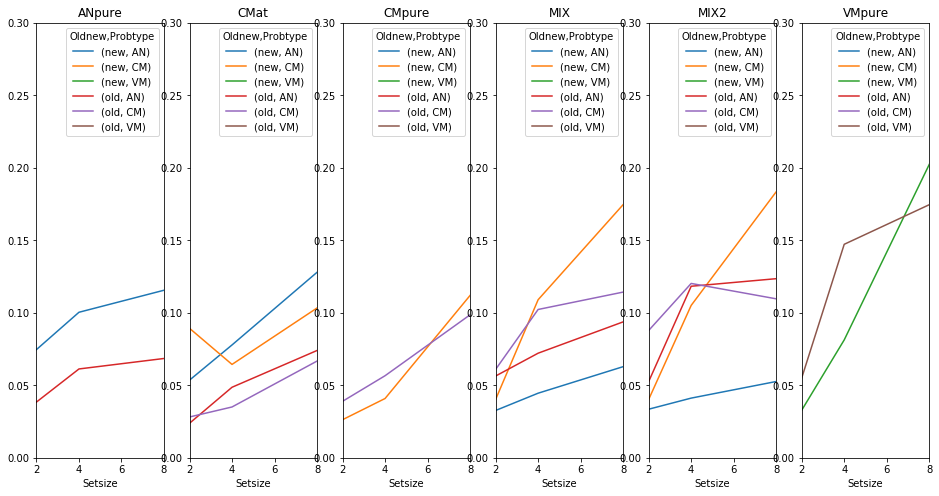

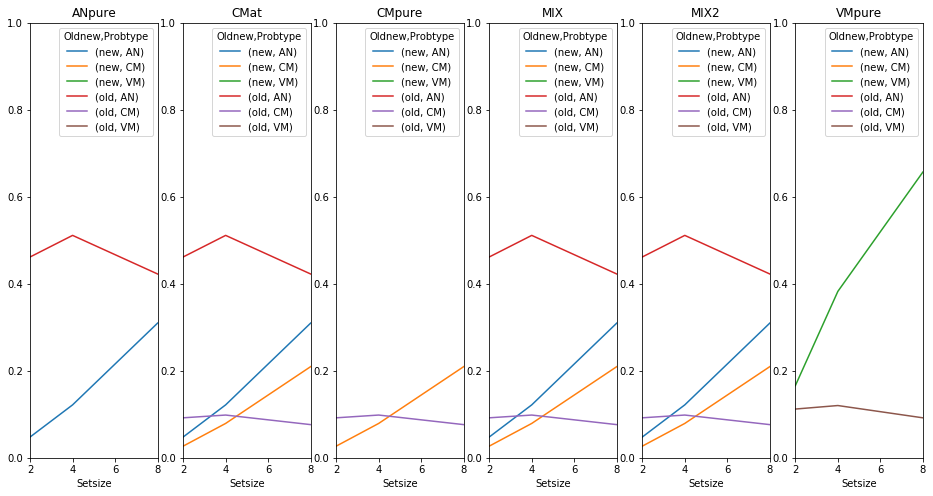

In [550]:
# Numitem = 16

param_dic = {
       "boost" : 0.60,
       "alpha" : 0.2, 
       "alpha_AN":0.278,

       "beta" : 1.228,
       "beta_AN": 2.011,
       "s" : 0.2,
       "c" : 0.587,
#        "LMT_old" : np.zeros(shape = Numitem),
#        "LMT_new" : np.zeros(shape = Numitem),
       "Old_crit" : 3,
       "New_crit" : -3,
       "t0" : 700,
       "kao" : 38,
       "IR_old_CM_old" : 0.23,
    
       "IR_old_AN_old" : 0,
       "IR_old_VM_old": 0.143,

       "IR_new_CM_new" : 0.623,
       "IR_new_AN_new" : 0,
       "IR_new_VM_new": 0.039,
    
    #the followings doesn't to adjust
       "IR_old_CM_new" : 0,
    
       "IR_old_AN_new" : 0,
       "IR_old_VM_new": 0,

       "IR_new_CM_old" : 0,
       "IR_new_AN_old" : 0,
       "IR_new_VM_old": 0
}

for key,val in param_dic.items(): exec(key + '=val')

    
df_all_crt, df_all_err = finalRW(df_org)
# walk unit to time unit}
# pred_raw_rt, predi_resp = Random_Walk(df, "CMpure", param_dic)

# actual_resp = df[df['FileCondi']=='CMpure']['Response']
# predi_resp = predi_resp

# for key,val in param_dic.items(): eval(key + '=val')

def all_plot(df_all_aggnew,plotwhaty,ylim):
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "Error",(0,0.3))
all_plot(df_all_aggnew, "pred_error",(0,1))

## correct RT plot

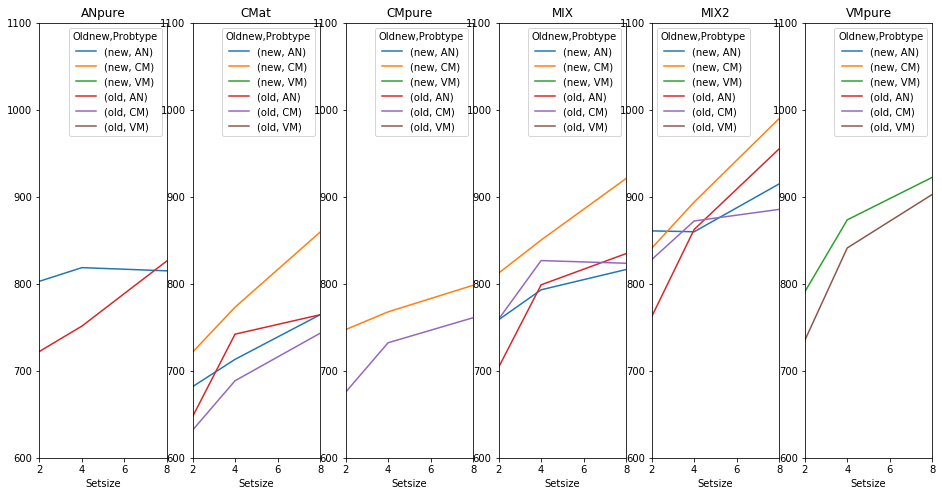

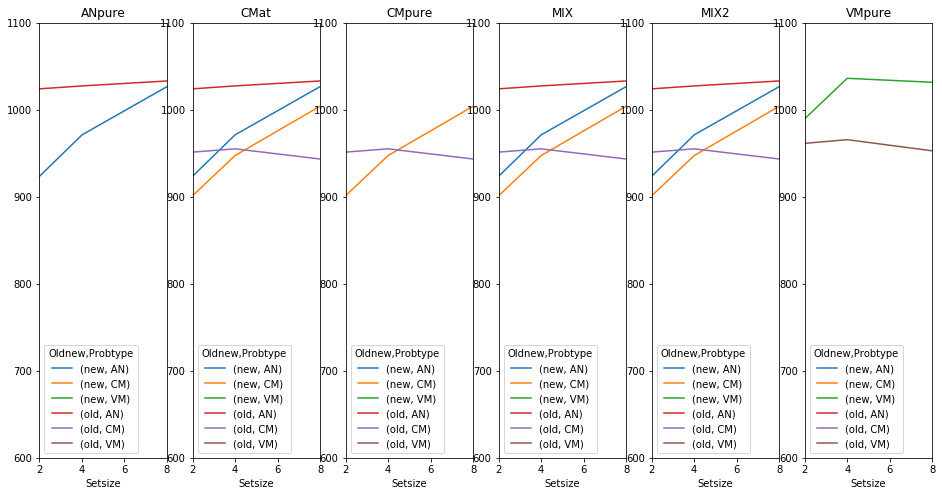

In [505]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_crt.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
# df_all_aggnew

all_plot(df_all_aggnew, "RT",(600,1100))
all_plot(df_all_aggnew, "pred_rt",(600,1100))

# Parella search

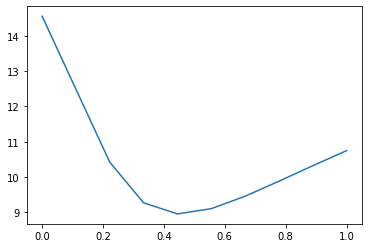

0.4444444444444444

In [543]:
def plot_parm(param_name, filename, constrain):
    name = filename
    # param_name = 'alpha_AN'
    parm_range = constrain
    niter= 10



    # navg = 1
    all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

    wsse_s = pd.DataFrame()

    i = 0
    # now = np.zeros((niter, calc_wssd(df, name).size))
    for i_s in all_s:

        param_dic[param_name] = i_s
        make_global(param_dic)

        wsse_s["iter"+str(i)] = [calc_wssd(df_org, name)]#.to_numpy()

        i+=1

    # wsse_s

    plt.figure()
    plt.plot(all_s, wsse_s.iloc[0])
    plt.show()

    minindex = wsse_s.iloc[0].to_numpy().argmin()

    param_dic[param_name] = all_s[minindex]
    make_global(param_dic)
    
    return(all_s[minindex])
plot_parm("alpha_AN","MIX", [0,1])

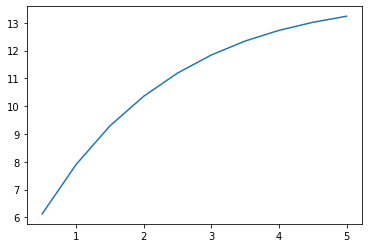

0.5

In [549]:
plot_parm("alpha","MIX", [0.5,5])

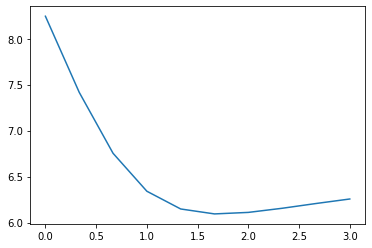

1.6666666666666665

In [545]:
plot_parm("beta_AN","MIX", [0,3])

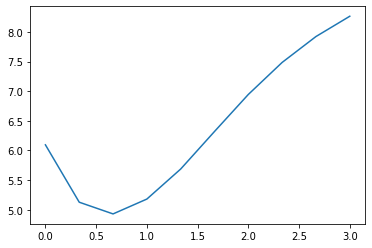

0.6666666666666666

In [548]:
plot_parm("beta","MIX", [0,3])

## Search s

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


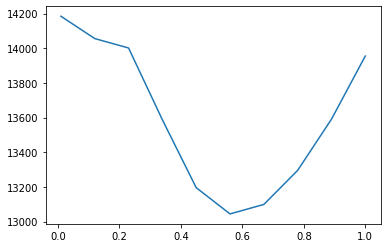

0.56


's'

In [742]:
name = "CMpure"
param_name = 's'
parm_range = [0.01, 1]
niter=10


# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

# # wsse_s * 10**-7
# i=0
# for i in range(8):
#     plt.figure()
#     plt.plot(range(wsse_s.iloc[i].size), wsse_s.iloc[i])
#     plt.show()
    
minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')
param_name

## parall search

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


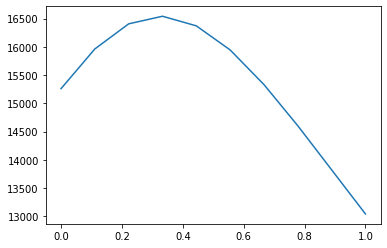

1.0


In [743]:
name = "CMpure"
param_name = 'c'
parm_range = [0, 1]
niter=10

# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()
    
minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')

## Old_crit

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


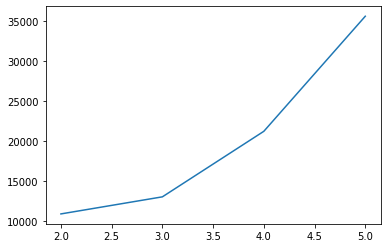

2.0
[2. 3. 4. 5.]


In [744]:
name = "CMpure"
param_name = 'Old_crit'
parm_range = [2, 5]
niter= parm_range[1]-parm_range[0]+1


# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])
print(all_s)
param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')

## New_crit

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


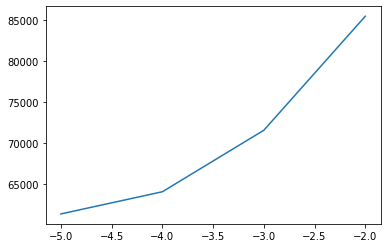

-5.0


In [746]:
name = "MIX"
param_name = 'New_crit'
parm_range = [-5, -2]
niter= parm_range[1]-parm_range[0]+1



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()
    
minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')

## t0

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


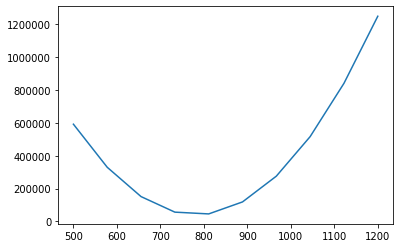

811.1111111111111


In [749]:
name = "MIX"
param_name = 't0'
parm_range = [500, 1200]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


## kao

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


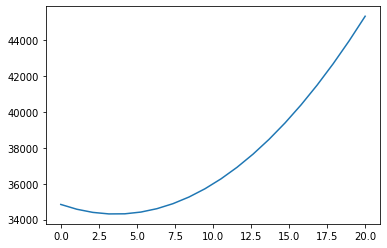

3.1578947368421053


In [750]:
name = "MIX"
param_name = 'kao'
parm_range = [0, 20]
niter= 20



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')

## alpha

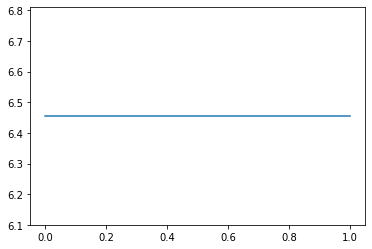

0.0


In [541]:
name = "CMpure"
param_name = 'alpha_AN'
parm_range = [0, 1]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    make_global(param_dic)

    wsse_s["iter"+str(i)] = [calc_wssd(df_org, name)]#.to_numpy()
        
    i+=1
    
# wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()
    
minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
make_global(param_dic)

## beta

In [513]:
name = "CMpure"
param_name = 'beta'
parm_range = [0, 3]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


KeyError: "Columns not found: 'Error'"

## IR_old_CM

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


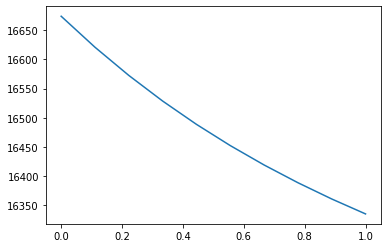

1.0


In [754]:
name = "CMpure"
param_name = 'IR_old_CM'
parm_range = [0, 1]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


## IR_old_AN

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


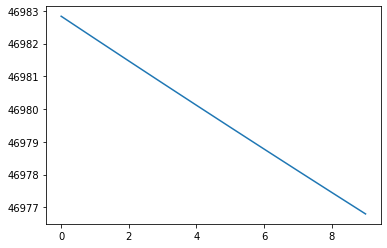

1.0


In [305]:
name = "MIX"
param_name = 'IR_old_AN'
parm_range = [0, 1]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


## IR_old_VM  

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


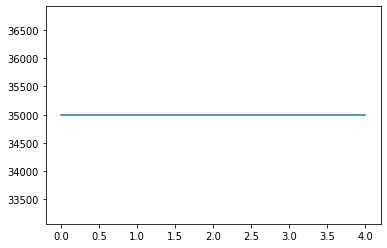

0.0


In [758]:
name = "MIX"
param_name = 'old_VM'
parm_range = [0, 4]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


## IR_new_CM  

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


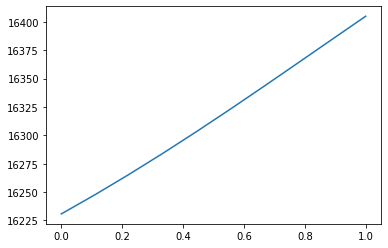

0.0


In [756]:
name = "CMpure"
param_name = 'IR_new_CM'
parm_range = [0, 1]
niter= 10



# navg = 1
all_s = np.linspace(parm_range[0], parm_range[1],num = niter)

wsse_s = pd.DataFrame()

i = 0
# now = np.zeros((niter, calc_wssd(df, name).size))
for i_s in all_s:
    
    param_dic[param_name] = i_s
    for key,val in param_dic.items(): exec(key + '=val')

    wsse_s["iter"+str(i)] = calc_wssd(df, name)#["mean"].to_numpy()
        
    i+=1
    
wsse_s

plt.figure()
plt.plot(all_s, wsse_s.iloc[0])
plt.show()

minindex = wsse_s.iloc[0].to_numpy().argmin()
print(all_s[minindex])

param_dic[param_name] = all_s[minindex]
for key,val in param_dic.items(): exec(key + '=val')


## Final Random Walk

In [532]:
# names = df["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

# for iname in names:
# #     print(iname)
#     pred_rt, pred_correct = calc_theoretical_RW(df, iname)
#     df_sub = df[df["FileCondi"] == iname]
#     df[df["FileCondi"] == iname]["pred_rt"] = pred_rt
#     df[df["FileCondi"] == iname]["pred_error"] = 1- pred_correct

# df_sub_agg = df.groupby(["FileCondi","Oldnew","Setsize","Probtype"])[["RT","Error","pred_rt","pred_error"]].agg(["mean"])

# df_sub_agg['SSD_RT'] = (df_sub_agg["RT"] - df_sub_agg["pred_rt"])**2
# df_sub_agg['SSD_ER'] = (df_sub_agg["Error"] - df_sub_agg["pred_error"])**2

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KeyError: "Columns not found: 'pred_rt', 'pred_error'"

C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,pred_error
,,,,,,mean,
2,new,2,AN,0,MIX,0.032641,0.082309
6,new,2,CM,0,MIX,0.040214,0.016192
11,new,4,AN,0,MIX,0.044568,0.220673
15,new,4,CM,0,MIX,0.109043,0.049394
20,new,8,AN,0,MIX,0.062874,0.468856
24,new,8,CM,0,MIX,0.174648,0.139402
29,old,2,AN,1,MIX,0.051282,0.190890
33,old,2,AN,2,MIX,0.061538,0.451230
37,old,2,CM,1,MIX,0.075581,0.127445


In [235]:
df_sub_err

,Oldnew,Setsize,Probtype,Lag,FileCondi,Error
,,,,,,mean
0,new,2,AN,0,ANpure,0.074648
1,new,2,AN,0,CMat,0.053571
2,new,2,AN,0,MIX,0.032641
3,new,2,AN,0,MIX2,0.033520
4,new,2,CM,0,CMat,0.089337
...,...,...,...,...,...,...
148,old,8,VM,4,VMpure,0.216495
149,old,8,VM,5,VMpure,0.122222
150,old,8,VM,6,VMpure,0.336957


In [481]:
np.array(\
    np.array([eval(['pred_rt'+ np.arange(1,4).astype(str)[i] for i in range(3)][i]).tolist() \
              for i in range(3)]).flatten('F')[0])

array([ 849.2267474 ,  966.52530387,  853.59759464, ...,  839.03160314,
        853.85999353, 1010.34286576])

In [236]:
df_all_crt.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"]).agg(["mean"])#.apply(lambda x: x)

C:\Users\naszh\Anaconda3\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


RT      pred_rt
                                             mean             
                                             mean         mean
Oldnew Setsize Probtype Lag FileCondi                         
new    2       AN       0   ANpure     802.972603   919.385114
                            CMat       681.754717   919.385114
                            MIX        758.693252   919.385114
                            MIX2       860.904624   919.385114
               CM       0   CMat       721.398734  1022.731941
...                                           ...          ...
old    8       VM       4   VMpure     896.421053   851.452873
                        5   VMpure     908.658228   851.545563
                        6   VMpure     962.377049   851.605119
                        7   VMpure     942.743590   851.646353
                        8   VMpure     965.583333   851.676454

[153 rows x 2 columns]

C:\Users\naszh\Anaconda3\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


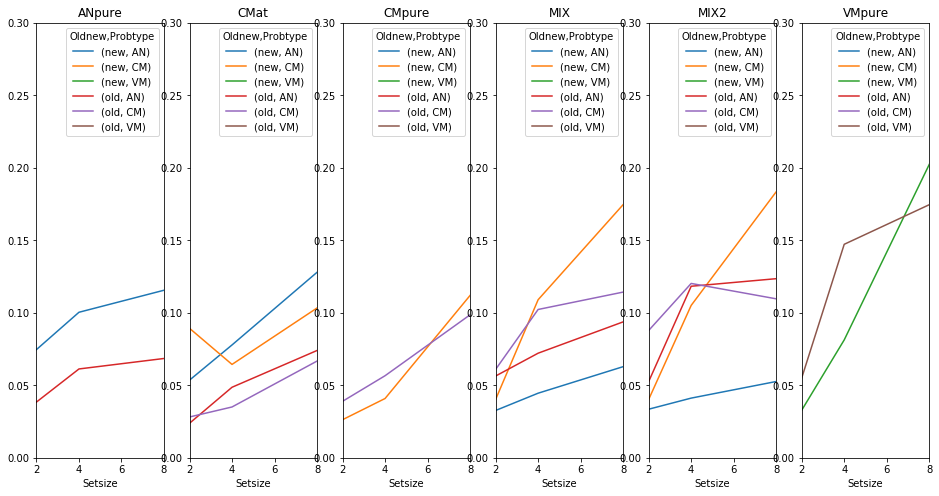

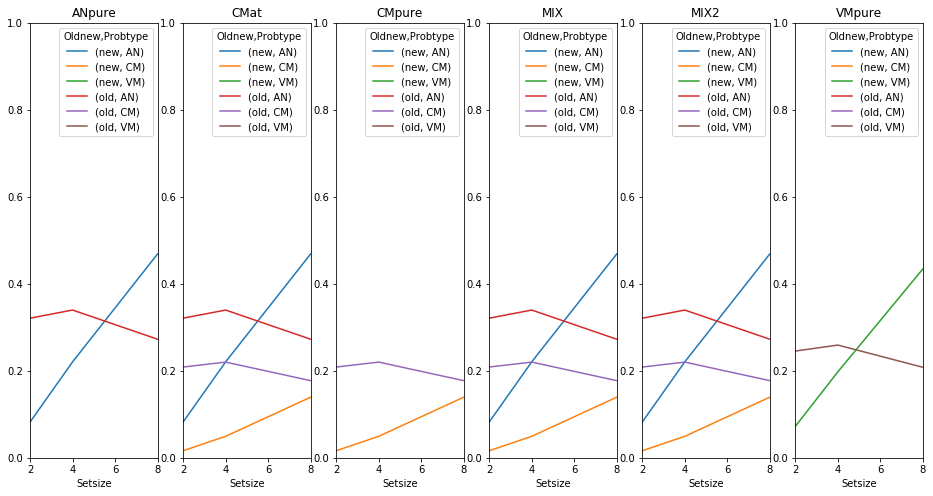

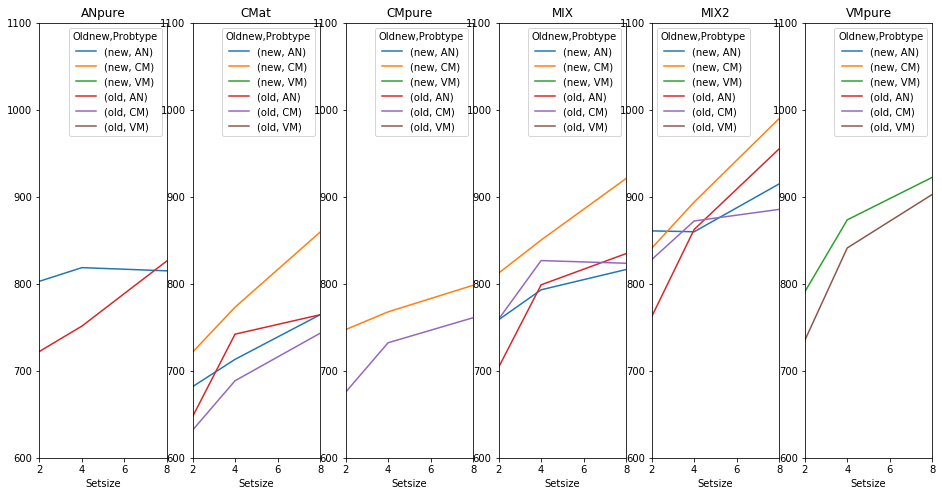

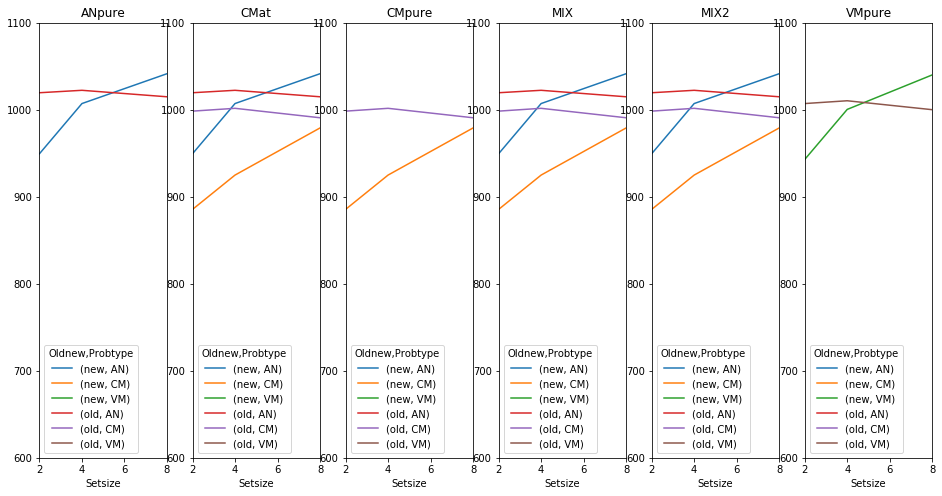